In [1]:
# pip install ftfy regex tqdm
# pip install git+https://github.com/openai/CLIP.git

In [2]:
import numpy as np
import torch
from pkg_resources import packaging # DEPRECATED

print("Torch version:", torch.__version__)


Torch version: 2.5.1+cpu


C:\Users\cdlar\AppData\Local\Temp\ipykernel_10492\3207500102.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging # DEPRECATED


In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
#model, preprocess = clip.load("ViT-B/32")
#model.cuda().eval()
model, preprocess = clip.load("ViT-B/32", device="cpu")  # Specify CPU explicitly
model.eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x0000014B72950EA0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [6]:
long_text = "This is a very long sentence designed to test the behavior of the CLIP tokenizer when the input exceeds the maximum allowed token length. Let's see what happens here."

# Tokenize
tokens = clip.tokenize([long_text])

print(tokens)  # Notice the size will be 77, the max length for ViT-B/32
print(tokens.shape)  # Should be (1, 77)

tensor([[49406,   589,   533,   320,  1070,  1538, 12737,  4486,   531,  1628,
           518, 10461,   539,   518,  9289, 32634, 23895,   827,   518, 16952,
         49353,   518, 13162,  7885, 17134, 10130,   269,  1094,   568,   862,
           768,  4988,   763,   269, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)
torch.Size([1, 77])


In [7]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt

from PIL import Image
from collections import OrderedDict

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
# images in skimage to use and their textual descriptions
descriptions = {
    "page": "a page of text about segmentation",
    "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    "rocket": "a rocket standing on a launchpad",
    "motorcycle_right": "a red motorcycle standing in a garage",
    "camera": "a person looking at a camera on a tripod",
    "horse": "a black-and-white silhouette of a horse", 
    "coffee": "a cup of coffee on a saucer"
}

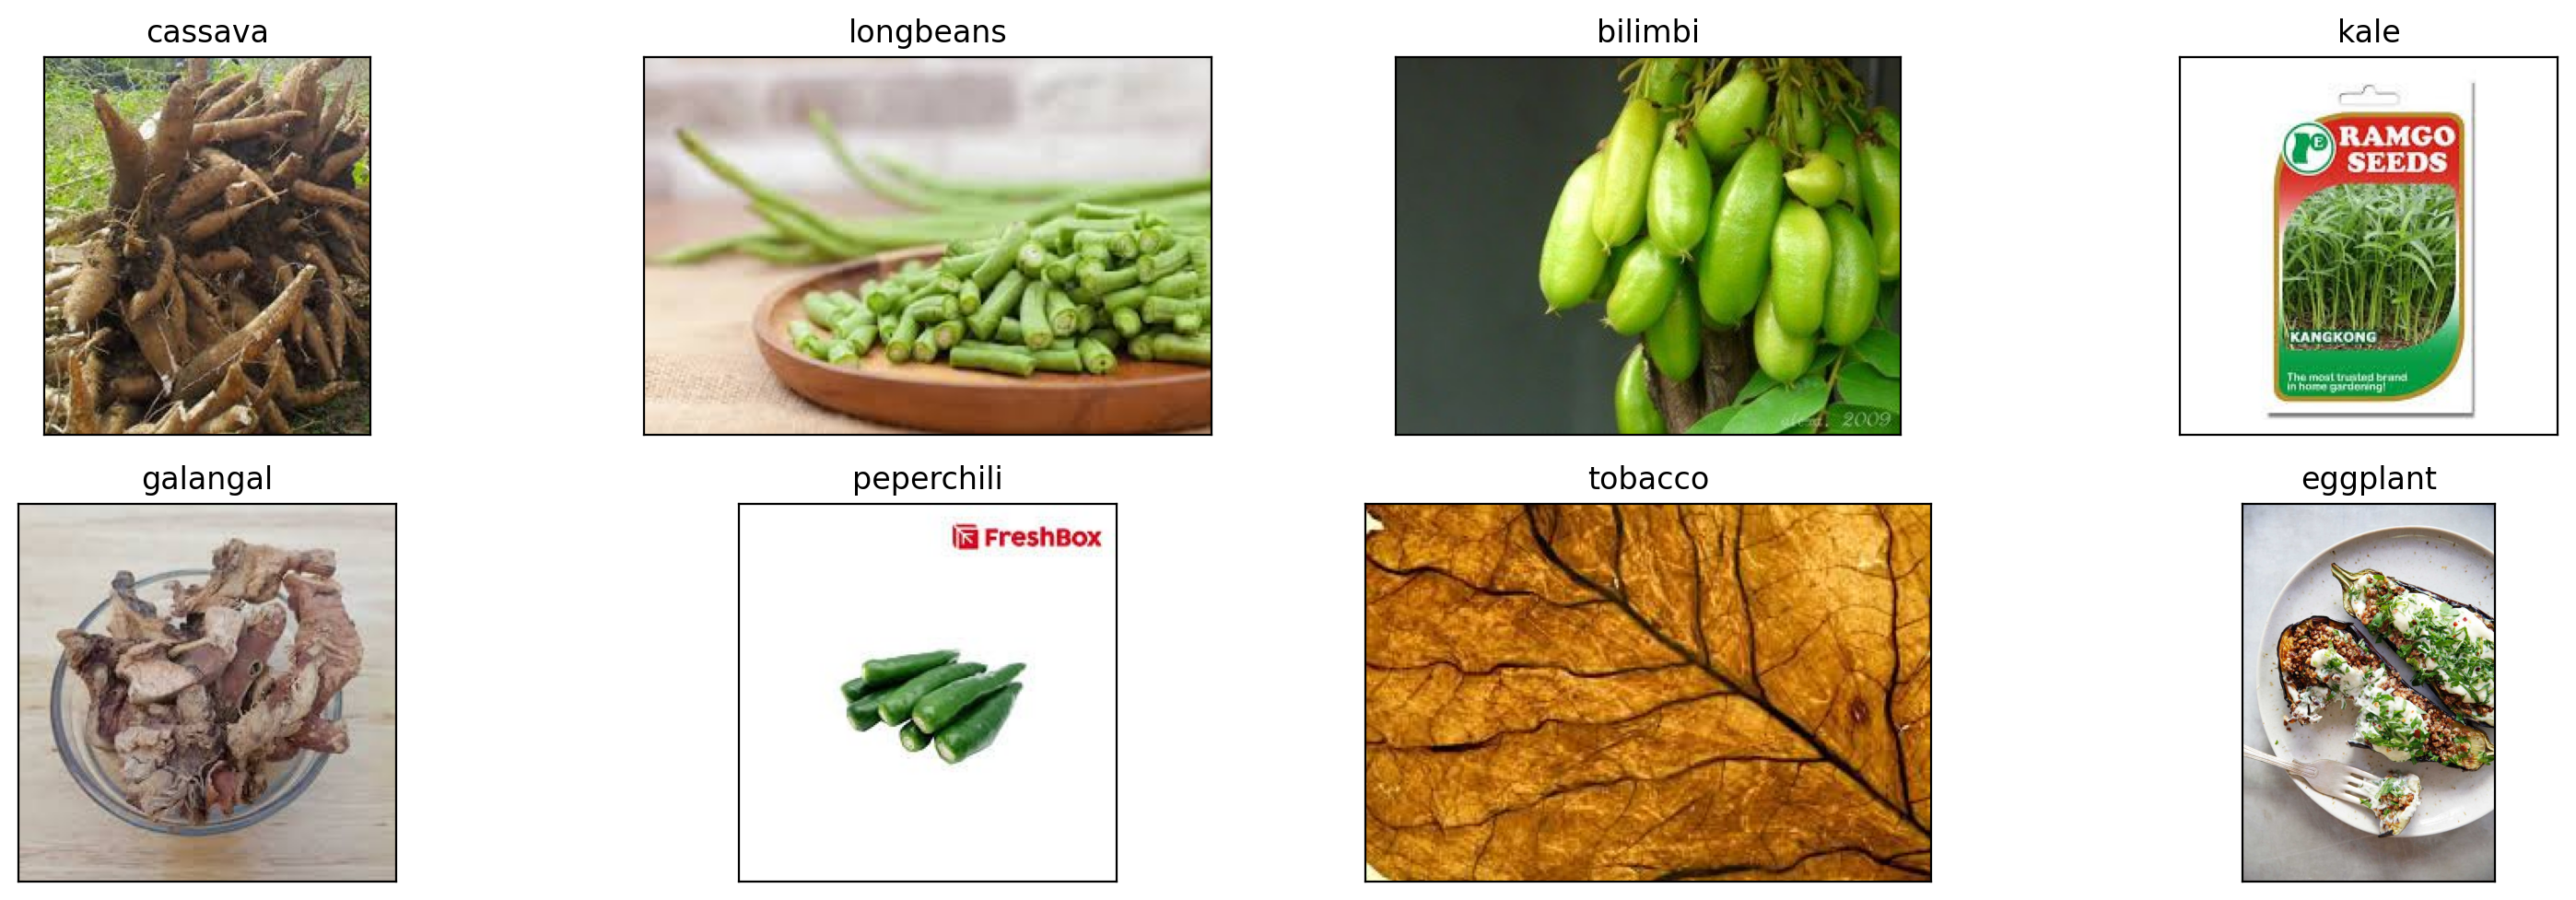

In [28]:
from datasets import load_random_images

# Paths and directories
dataset_dir = "../dataset" 
split = "train"  # Change to "val" or "test" as needed
num_images = 8

images_and_classes = load_random_images(dataset_dir, split, num_images)

# Plot images in a 4x2 grid
plt.figure(figsize=(16, 5))
for i, (image, description) in enumerate(images_and_classes):
    plt.subplot(2, 4, i + 1)  # 4 rows, 2 columns
    plt.imshow(image)
    plt.title(description)
    plt.xticks([])  # Optional: Remove axis ticks
    plt.yticks([])  # Optional: Remove axis ticks
    
plt.tight_layout()
plt.show()


In [36]:
import kagglehub

dataset_dir = os.path.join(os.getcwd(), "../disease_data")  # Modify this path as needed

os.makedirs(dataset_dir, exist_ok=True)

# Download the dataset to your project directory
kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset", path=dataset_dir)

KaggleApiHTTPError: 404 Client Error.

Resource not found at URL: https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/versions/2
Please make sure you specified the correct resource identifiers.